In [3]:
import os
import pandas as pd
import numpy as np
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import cv2

from sklearn import model_selection
from PIL import Image
from skimage import exposure

from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

# Datos

In [1]:
path = '/home/mr1142/Documents/Data/NIH'

In [4]:
df = pd.read_csv(os.path.join(path, 'Data_Entry_2017.csv'))
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


## Labels

In [5]:
labels = np.unique(df['Finding Labels'])
labels = '|'.join(labels)
labels = labels.split('|')
labels = np.unique(labels).tolist()

In [6]:
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [7]:
for lab in labels:
    df[lab] = pd.NA

In [8]:
def fill_label(information, label):
    positive_labels = information.split('|')
    if label in positive_labels:
        return 1
    return 0

In [9]:
for lab in labels:
    df[lab] = list(map(lambda x: fill_label(x, lab), df['Finding Labels'].tolist()))

In [10]:
df = df.sample(frac=1).reset_index(drop = True)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00017981_004.png,No Finding,4,17981,43,F,PA,2992,2991,0.143000,...,0,0,0,0,0,1,0,0,0,0
1,00002182_001.png,No Finding,1,2182,66,F,PA,2544,3056,0.139000,...,0,0,0,0,0,1,0,0,0,0
2,00012949_000.png,No Finding,0,12949,74,M,PA,2992,2991,0.143000,...,0,0,0,0,0,1,0,0,0,0
3,00018232_000.png,No Finding,0,18232,47,F,PA,2021,2021,0.194311,...,0,0,0,0,0,1,0,0,0,0
4,00015534_000.png,No Finding,0,15534,19,M,PA,2992,2991,0.143000,...,0,0,0,0,0,1,0,0,0,0


In [11]:
print(sum(df.Pneumonia == 1))
print(sum(df['No Finding'] == 1))

1431
60361


In [12]:
n = 1000

In [13]:
neumo = df[df.Pneumonia == 1][0:n]
normal = df[df['No Finding'] == 1][0:n]

In [14]:
df = pd.concat([neumo, normal]).reset_index(drop = True)
df = df.sample(frac=1).reset_index(drop = True)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00011180_005.png,No Finding,5,11180,73,F,AP,2500,2048,0.168000,...,0,0,0,0,0,1,0,0,0,0
1,00026389_002.png,Pneumonia,2,26389,76,M,PA,2021,2021,0.194311,...,0,0,0,0,0,0,0,0,1,0
2,00004976_000.png,Atelectasis|Cardiomegaly|Pneumonia,0,4976,63,F,PA,2048,2500,0.171000,...,0,0,0,0,0,0,0,0,1,0
3,00013615_004.png,Pneumonia,4,13615,9,F,AP,2048,2500,0.168000,...,0,0,0,0,0,0,0,0,1,0
4,00016790_004.png,No Finding,4,16790,29,M,PA,2992,2991,0.143000,...,0,0,0,0,0,1,0,0,0,0


In [24]:
imgs_dict = charge_ims(df['Image Index'])

0.0005%; 0.001%; 0.0015%; 0.002%; 0.0025%; 0.003%; 0.0035%; 0.004%; 0.0045%; 0.005%; 0.0055%; 0.006%; 0.0065%; 0.007%; 0.0075%; 0.008%; 0.0085%; 0.009%; 0.0095%; 0.01%; 0.0105%; 0.011%; 0.0115%; 0.012%; 0.0125%; 0.013%; 0.0135%; 0.014%; 0.0145%; 0.015%; 0.0155%; 0.016%; 0.0165%; 0.017%; 0.0175%; 0.018%; 0.0185%; 0.019%; 0.0195%; 0.02%; 0.0205%; 0.021%; 0.0215%; 0.022%; 0.0225%; 0.023%; 0.0235%; 0.024%; 0.0245%; 0.025%; 0.0255%; 0.026%; 0.0265%; 0.027%; 0.0275%; 0.028%; 0.0285%; 0.029%; 0.0295%; 0.03%; 0.0305%; 0.031%; 0.0315%; 0.032%; 0.0325%; 0.033%; 0.0335%; 0.034%; 0.0345%; 0.035%; 0.0355%; 0.036%; 0.0365%; 0.037%; 0.0375%; 0.038%; 0.0385%; 0.039%; 0.0395%; 0.04%; 0.0405%; 0.041%; 0.0415%; 0.042%; 0.0425%; 0.043%; 0.0435%; 0.044%; 0.0445%; 0.045%; 0.0455%; 0.046%; 0.0465%; 0.047%; 0.0475%; 0.048%; 0.0485%; 0.049%; 0.0495%; 0.05%; 0.0505%; 0.051%; 0.0515%; 0.052%; 0.0525%; 0.053%; 0.0535%; 0.054%; 0.0545%; 0.055%; 0.0555%; 0.056%; 0.0565%; 0.057%; 0.0575%; 0.058%; 0.0585%; 0.059%; 0.

## Imagenes

### Cargamos el modelo de segmentación

In [15]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [16]:
def loss_mask(y_true, y_pred):
    y_pred = sub_mask(y_pred)
    y_true = sub_mask(y_true)
    return abs(y_true - y_pred)


def MyLoss(y_true, y_pred):
    # Loss 1
    loss1 = ex.dice_coef_loss(y_true, y_pred)
    # Loss 2
    loss2 = loss_mask(y_true, y_pred)
    loss = loss1 + 0.5*loss2
    return loss

In [17]:
new_model = tf.keras.models.load_model('/home/mr1142/Documents/Data/models/unet_final_renacimiento_validation_6.h5', 
                                     custom_objects={"MyLoss": MyLoss, 
                                                     "loss_mask": loss_mask, 
                                                     "dice_coef_loss": dice_coef_loss,
                                                     "dice_coef": dice_coef})

### Funciones para aplicar from skimage import measure

In [15]:
from skimage import measure
from scipy import ndimage

In [16]:
def normalize(img):
    return (img - np.mean(img))/ np.std(img)

In [17]:
def quitar_trozos(mask):
    mask = measure.label(mask)
    ntotal = {k: (k==mask).sum() for k in np.unique(mask) if k >0}
    k = list(ntotal.keys())[np.argmax(list(ntotal.values()))]
    mask = k==mask
    mask = ndimage.binary_fill_holes(mask, structure=np.ones((5,5)))
    return mask


def recolor(img):
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        print('', end = '')
    return img


def recolor_resize(img, pix=256):
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        print('', end = '')
    img = cv2.resize(img, (pix, pix))
    img = np.expand_dims(img, axis=-1)
    return img


def des_normalize(img):
    return cv2.normalize(img, None, alpha = 0, beta = 255,
                         norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_16UC1)


def apply_mask(img, model):
    pix1 = img.shape[0]
    pix2 = img.shape[1]
    # Paso la imagen a escala de grises
    img = recolor(img)
    # Creo una nueva imagen con las dimensiones de entrada al modelo
    img_2 = normalize(recolor_resize(img, 256))[np.newaxis,...]
    # Genero la mascara
    mask = model.predict(img_2)[0,...]
    # Escalo la mascara generada al tamaño de la imagen de entrada
    mask = cv2.resize(mask, (pix2, pix1))
    # Limpio la mascara
    mask = quitar_trozos(mask > 0.5)
    return img*mask

### Funciones para preparar las imagenes

In [18]:
pix = 512

In [19]:
def clahe(img):
    clahe = cv2.createCLAHE(clipLimit = 20)
    final_img = clahe.apply(img)
    return final_img

def get_prepared_img(path, model, pix):
    img = cv2.imread(path)
    segmented = des_normalize(apply_mask(img, model))
    segmented = recolor_resize(segmented, pix)
    segmented = clahe(segmented)
    return segmented

Cargo todas las imagenes y les aplico todos los filtros

In [20]:
def charge_ims(img_list, pix):
    names = []
    imgs = []
    subfolders = [f.path for f in os.scandir(path) if f.is_dir()]
    i = 0
    # De todas las imagenes que quiero cargar miro cuantas hay en cada carpeta y las cargo
    for folder in subfolders:
        folder_images = os.listdir(os.path.join(folder, 'images'))
        this_folder_imgs = set(img_list).intersection(folder_images)
        names = names + list(this_folder_imgs)
        for im in this_folder_imgs:
            i +=1
            imgs.append(get_prepared_img(folder + '/images/' + im, new_model, pix))
            print(str(i/len(img_list)) + '%', end = '; ')
    return {'name': names, 'imgs': imgs}

In [21]:
imgs_dict = charge_ims(df['Image Index'], pix)

NameError: name 'new_model' is not defined

Reordeno las imagenes en un array

In [28]:
images = np.zeros((len(df), pix, pix, 1))
for i in range(len(df)):
    index = [j for j in range(len(imgs_dict['name'])) if imgs_dict['name'][j] == df['Image Index'][i]]
    im = recolor_resize(imgs_dict['imgs'][index[0]], 512)
    images[i,...] = im

In [108]:
images.shape

(2000, 512, 512, 1)

## X e Y

In [30]:
Y = np.array(df['Pneumonia'])
X = images

In [31]:
neumo = X[Y == 1]
norm = X[Y == 0]

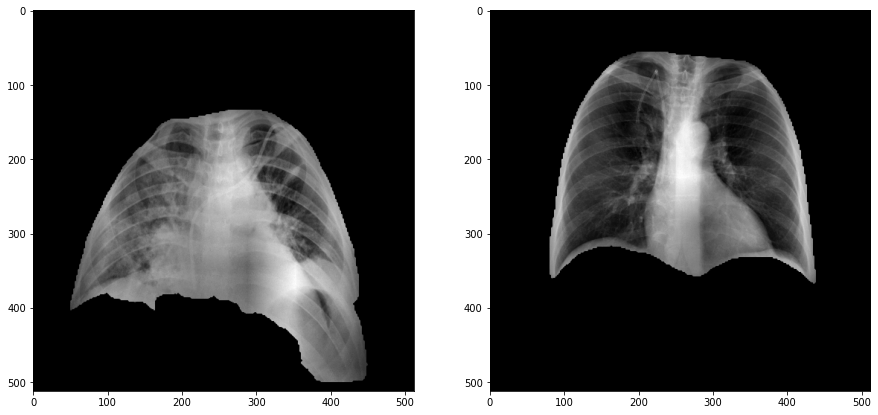

In [91]:
f, ax = plt.subplots(1,2, figsize=(15,15)) 
i = np.random.randint(0, len(neumo))
ax[0].imshow(neumo[i], cmap = 'gray')
ax[1].imshow(norm[i], cmap = 'gray')
f.show()

In [33]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.3, shuffle=True, stratify=Y )

# Modelo

## Red preentrenada EfficienNet B3

In [134]:
input_shape = (pix,pix,3)
conv_base = EfficientNetB3(weights="imagenet", include_top=False, input_shape=input_shape)

In [46]:
print(len(conv_base.layers))
print(len(conv_base.trainable_variables))

384
338


## Completo el modelo

In [47]:
model = models.Sequential()
model.add(layers.Conv2D(3,3,padding="same", input_shape=(pix,pix,1), activation='elu', name = 'conv_inicial'))
model.add(conv_base)
model.add(layers.Conv2D(32,3, padding='same', input_shape=(8,8,1280), activation='selu', name = 'conv_posterior'))
model.add(layers.MaxPool2D(pool_size = (2,2), padding='same', name = 'first_pooling'))
model.add(layers.Conv2D(64,3, padding='same', input_shape=(4,4,1280), activation='selu', name = 'last_convolution'))
model.add(layers.GlobalMaxPooling2D(name="general_max_pooling"))
model.add(layers.Dropout(0.2, name="dropout_out"))
model.add(layers.Dense(1, activation="sigmoid", name="fc_out"))

In [132]:
conv_base.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 224, 224, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_2[0][0]            
_____________________________________________________________________________________

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_inicial (Conv2D)        (None, 512, 512, 3)       30        
_________________________________________________________________
efficientnetb3 (Functional)  (None, 16, 16, 1536)      10783535  
_________________________________________________________________
conv_posterior (Conv2D)      (None, 16, 16, 32)        442400    
_________________________________________________________________
first_pooling (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
last_convolution (Conv2D)    (None, 8, 8, 64)          18496     
_________________________________________________________________
general_max_pooling (GlobalM (None, 64)                0         
_________________________________________________________________
dropout_out (Dropout)        (None, 64)                0

## Callback

In [31]:
log_dir = "/home/mr1142/Documents/Data/logs/fit/image_class_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      update_freq='batch',
                                                      histogram_freq=1)

# Entrenamiento

## Hiperparametros

In [49]:
lr = 1e-4
opt = tf.keras.optimizers.Adam(learning_rate = lr)
loss = loss = 'binary_crossentropy'
met = ['BinaryAccuracy', 'Precision', 'AUC']

In [50]:
batch = 8
epoch = 500

### Especificación por capas

In [57]:
conv_base.trainable = True

Entrenamos desde la capa 300

In [58]:
fine_tune_at = 200

for layer in conv_base.layers[:fine_tune_at]:
    layer.trainable = False

In [59]:
print(len(model.layers))
print(len(model.trainable_variables))

8
172


### Compilación

In [60]:
model.compile(optimizer=opt, loss = loss , metrics = met)

### Entrenamiento

In [61]:
history = model.fit(X_train,Y_train,
                    batch_size = batch,
                    epochs = epoch,
                    # callbacks = tensorboard_callback,
                    validation_data = (X_test, Y_test),
                    shuffle = True,
                    validation_split = 0.2)

Epoch 1/500
140/140 [==============================] - 264s 398ms/step - loss: 1.1451 - binary_accuracy: 0.5330 - precision: 0.5286 - auc: 0.5564 - val_loss: 0.7316 - val_binary_accuracy: 0.5179 - val_precision: 0.5122 - val_auc: 0.5231
Epoch 2/500
140/140 [==============================] - 55s 395ms/step - loss: 0.8567 - binary_accuracy: 0.5199 - precision: 0.5197 - auc: 0.5481 - val_loss: 0.7539 - val_binary_accuracy: 0.5321 - val_precision: 0.5196 - val_auc: 0.5707
Epoch 3/500
140/140 [==============================] - 56s 398ms/step - loss: 0.7819 - binary_accuracy: 0.5499 - precision: 0.5414 - auc: 0.5721 - val_loss: 0.7211 - val_binary_accuracy: 0.5179 - val_precision: 0.5123 - val_auc: 0.5635
Epoch 4/500
140/140 [==============================] - 55s 396ms/step - loss: 0.7276 - binary_accuracy: 0.5661 - precision: 0.5621 - auc: 0.5891 - val_loss: 0.7244 - val_binary_accuracy: 0.5107 - val_precision: 0.5057 - val_auc: 0.5500
Epoch 5/500
140/140 [==============================] - 

KeyboardInterrupt: 